In [1]:
import os
os.chdir('C:/Users/raffa/PycharmProjects/PortfolioProject')
import pandas as pd
from sqlalchemy import create_engine
import sqlite3
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from src.data_exploration.data_exploration import *

In [2]:
df = read_sqlite_table('housedata', './data/processed/rome_house_explored.db')

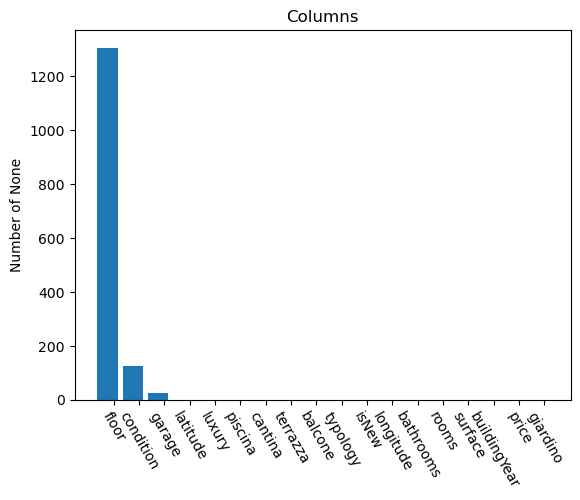

In [3]:
plot_bar(df,missing_value='None')

In [4]:
df = replace_missing_values(df,missing_value='None')

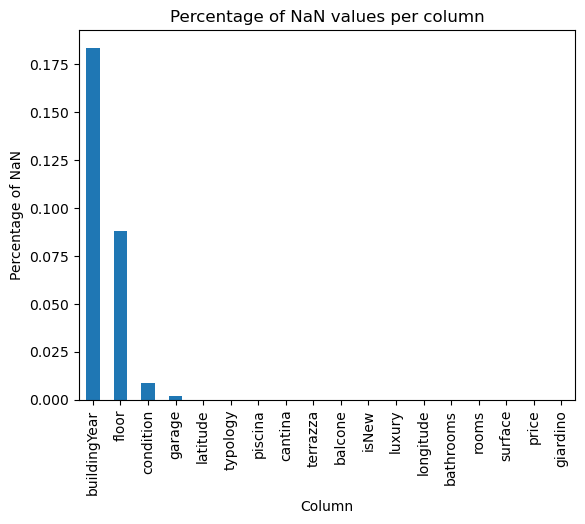

In [5]:
plot_nan_percentages(df)

In [6]:
class DataPreprocessor:
    
    def __init__(self, df):
        self.df = df
        
    def replace_with_nan(self,missing_values):
        self.df = self.df.replace(missing_values, np.nan)
        
        
    def train_test(self,train_size=0.8, seed=42):
        self.train = self.df.sample(frac=train_size, random_state=seed)
        self.test = self.df.drop(index=self.train.index)
    
    def plot_missing(self):
        
        cols_with_missing_train = pd.DataFrame()
        cols_with_missing_test = pd.DataFrame()

        for col in self.train.columns:
            if self.train[col].isna().sum()>0:    
                cols_with_missing_train[col] = self.train[col]

        for col in self.test.columns:
            if self.test[col].isna().sum()>0:    
                cols_with_missing_test[col] = self.test[col]
        if len(cols_with_missing_train)==0 and len(cols_with_missing_test)==0:
            print('No missing values')

        else:
            percentage_train = cols_with_missing_train.isna().sum()/len( cols_with_missing_train)
            percentage_train = percentage_train.sort_values(ascending=False)

            percentage_test = cols_with_missing_test.isna().sum()/len( cols_with_missing_test)
            percentage_test = percentage_test.sort_values(ascending=False)
            X = cols_with_missing_test.columns
            X_axis = np.arange(len(X))
            fig, ax = plt.subplots()  
            plt.bar(X_axis - 0.2, percentage_train, 0.4, label = 'Train')
            plt.bar(X_axis + 0.2, percentage_test, 0.4, label = 'Test')

            ax.set_xticks(X_axis, X, rotation = -45)
            ax.set_xlabel("Variables")
            ax.set_ylim([0, 1])
            ax.set_ylabel('% of Missing Values')
            ax.set_title('Missing Values')
            ax.legend()
            plt.show()

        plt.show()
    
    def replace_missing(self):

        for col in self.train_nomiss.columns:
            if self.train_nomiss[col].isna().sum()>0:
                
                if self.train[col].dtypes == 'object':
                    self.train_nomiss[col] = self.train_nomiss[col].replace(np.nan,self.train[col].mode()[0])
                    self.test_nomiss[col] = self.test_nomiss[col].replace(np.nan,self.train[col].mode()[0])
                    
                if is_numeric_dtype(self.train[col]):
                    self.train_nomiss[col] = self.train_nomiss[col].replace(np.nan,round(self.train[col].mean(),2))
                    self.test_nomiss[col] = self.test_nomiss[col].replace(np.nan,round(self.train[col].mean(),2))
                    
    def run_preprocessor(self,missing_values,train_size=0.8, seed=42):
        
        self.replace_with_nan(missing_values)
        self.split_train_test( train_size, seed)
        self.plot_missing()
        self.replace_missing()
        

In [7]:
dpp = DataPreprocessor(df)

In [8]:
dpp.train_test(train_size=0.8, seed=42)

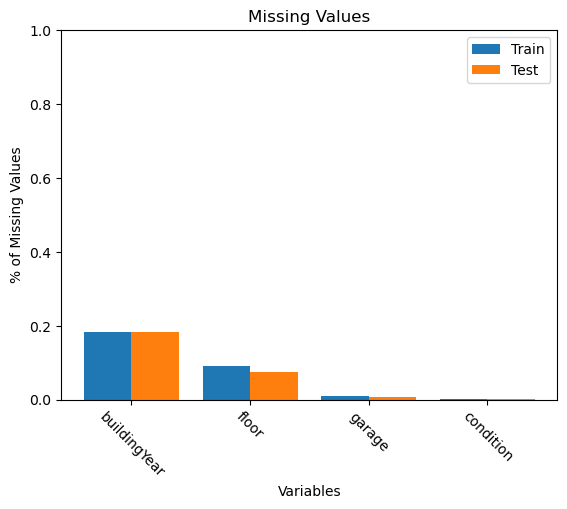

In [9]:
dpp.plot_missing()

In [45]:
def value_encoding(value,diz,train,sigma_proportion):
    if value not in diz.keys():
        mu = diz['missing_values'][0]
        sigma = diz['missing_values'][1]
        value_encoded = np.random.normal(mu, sigma*sigma_proportion, 1)[0]
    else:
        mu = diz[value][0]
        sigma = diz[value][1]
        value_encoded = np.random.normal(mu, sigma*sigma_proportion, 1)[0]
    return value_encoded

def mean_std_encoding(train, test, cols_to_encode, target, sigma_proportion, min_cat_n):

    encoding_diz = {}
    for col in cols_to_encode:
        train.loc[train.groupby(col)[col].transform('count').lt(min_cat_n), col] = np.nan
        diz = train.groupby(col).apply(lambda row: [row[target].mean(),row[target].std()]).to_dict()
        diz['missing_values'] = [train[target].mean(), train[target].std()]
        encoding_diz[col] = diz
        train[col] = train[col].apply(lambda row: value_encoding(row, diz, train, sigma_proportion))
        test[col] = test[col].apply(lambda row: value_encoding(row, diz, train, sigma_proportion))
    return  train, test, encoding_diz

In [166]:
dpp = DataPreprocessor(df)
dpp.train_test(train_size=0.8, seed=42)

In [167]:
train, test, encoding_diz = mean_std_encoding(dpp.train,
                                              dpp.test,
                                              cols_to_encode=['buildingYear','floor'],
                                              target='price',
                                              sigma_proportion=0.1,
                                              min_cat_n=20)

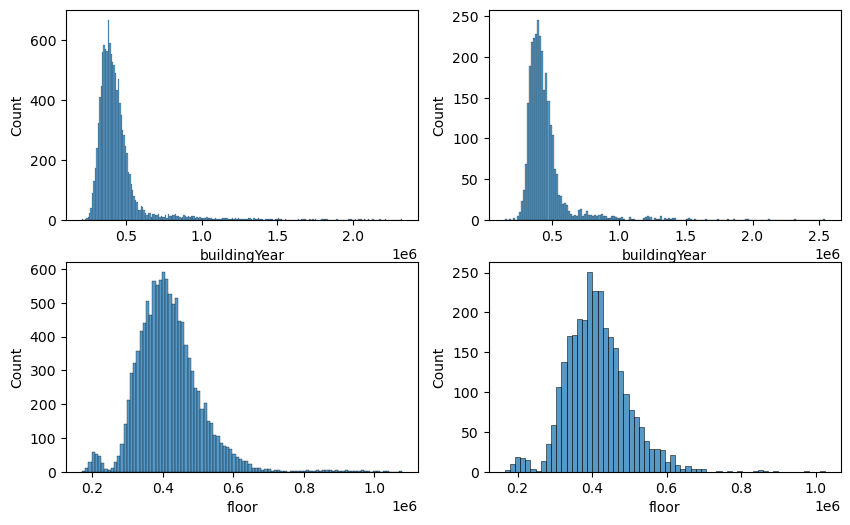

In [150]:
fig, ax = plt.subplots(2, 2,figsize=(10,6))
sns.histplot(x=train['buildingYear'],ax=ax[0,0])
sns.histplot(x=test['buildingYear'], ax=ax[0,1])
sns.histplot(x=train['floor'],ax=ax[1,0])
sns.histplot(x=test['floor'], ax=ax[1,1])
plt.show()

In [49]:
from sklearn.preprocessing import OneHotEncoder

In [151]:
train.dtypes

latitude        float64
longitude       float64
price           float64
buildingYear    float64
surface           int64
rooms            object
bathrooms        object
floor           float64
garage           object
isNew             int64
luxury            int64
typology         object
condition        object
balcone           int64
terrazza          int64
cantina           int64
piscina           int64
giardino          int64
dtype: object

In [168]:
train.columns

Index(['latitude', 'longitude', 'price', 'buildingYear', 'surface', 'rooms',
       'bathrooms', 'floor', 'garage', 'isNew', 'luxury', 'typology',
       'condition', 'balcone', 'terrazza', 'cantina', 'piscina', 'giardino'],
      dtype='object')

In [169]:
one_hot_cols = ['rooms', 'bathrooms','garage','typology','condition']

for col in one_hot_cols:
    print(train[col].unique())

['2' '3' '4' '1' '5+' '5']
['2' '1' '3+' '3']
['1' '0' '2' nan '3' '4']
['Appartamento' 'Attico - Mansarda' 'Villa' 'Villetta a schiera'
 'Casa indipendente' 'Loft' 'Rustico - Casale']
['Ottimo / Ristrutturato' 'Buono / Abitabile' 'Nuovo / In costruzione'
 'Da ristrutturare' nan]


In [170]:
one_hot_cols = ['rooms', 'bathrooms','garage','typology','condition']

for col in one_hot_cols:
    ohe= OneHotEncoder(drop=None)
    train_ohe = ohe.fit_transform(train[[col]])
    test_ohe = ohe.transform(test[[col]])
    
    train[ohe.get_feature_names_out(input_features=None)] = train_ohe.toarray()
    test[ohe.get_feature_names_out(input_features=None)] = test_ohe.toarray()
    train = train.drop(ohe.get_feature_names_out(input_features=None)[-1], axis=1)
    test = test.drop(ohe.get_feature_names_out(input_features=None)[-1], axis=1)

In [171]:
train = train.select_dtypes(exclude=['object'])

In [175]:
train.columns

Index(['latitude', 'longitude', 'price', 'buildingYear', 'surface', 'floor',
       'isNew', 'luxury', 'balcone', 'terrazza', 'cantina', 'piscina',
       'giardino', 'rooms_1', 'rooms_2', 'rooms_3', 'rooms_4', 'rooms_5',
       'bathrooms_1', 'bathrooms_2', 'bathrooms_3', 'garage_0', 'garage_1',
       'garage_2', 'garage_3', 'garage_4', 'typology_Appartamento',
       'typology_Attico - Mansarda', 'typology_Casa indipendente',
       'typology_Loft', 'typology_Rustico - Casale', 'typology_Villa',
       'condition_Buono / Abitabile', 'condition_Da ristrutturare',
       'condition_Nuovo / In costruzione', 'condition_Ottimo / Ristrutturato'],
      dtype='object')

In [176]:
train = train[['latitude', 'longitude', 'buildingYear', 'surface', 'floor',
       'isNew', 'luxury', 'balcone', 'terrazza', 'cantina', 'piscina',
       'giardino', 'rooms_1', 'rooms_2', 'rooms_3', 'rooms_4', 'rooms_5',
       'bathrooms_1', 'bathrooms_2', 'bathrooms_3', 'garage_0', 'garage_1',
       'garage_2', 'garage_3', 'garage_4', 'typology_Appartamento',
       'typology_Attico - Mansarda', 'typology_Casa indipendente',
       'typology_Loft', 'typology_Rustico - Casale', 'typology_Villa',
       'condition_Buono / Abitabile', 'condition_Da ristrutturare',
       'condition_Nuovo / In costruzione', 'condition_Ottimo / Ristrutturato', 'price']]

<Axes: >

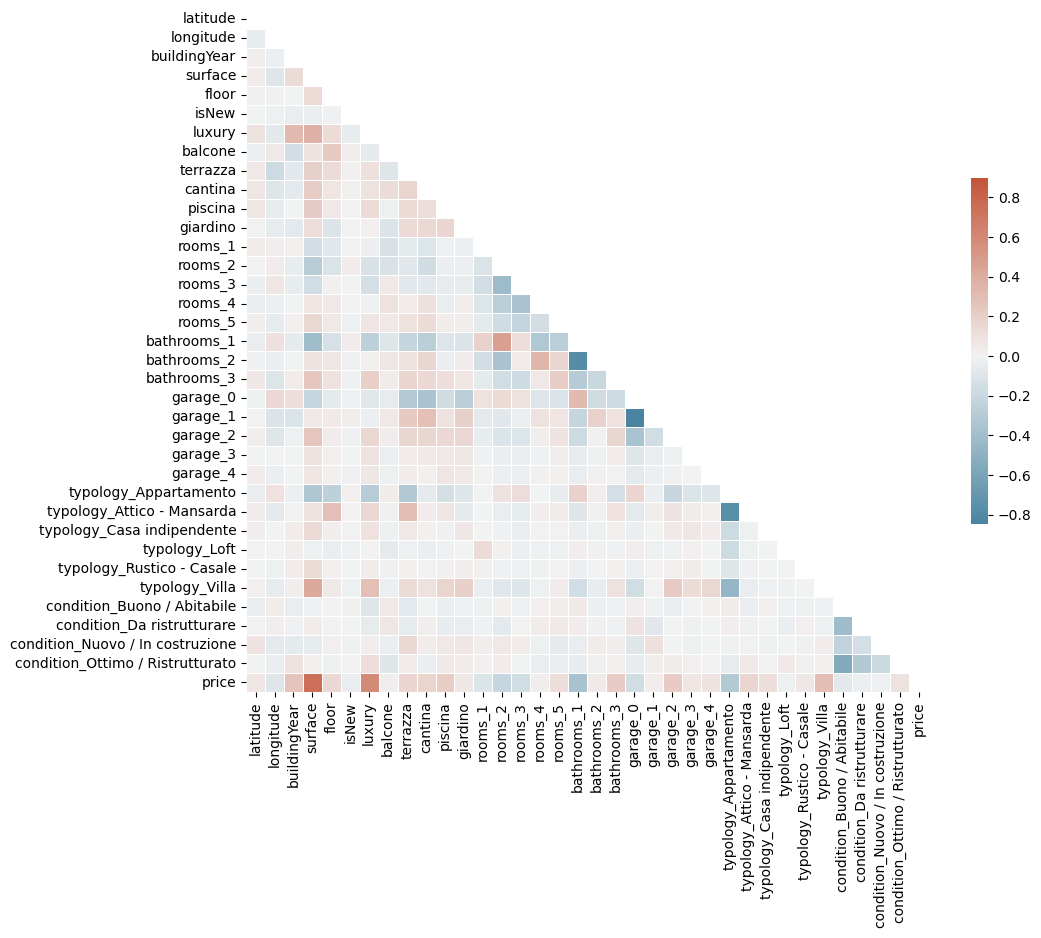

In [177]:
# Compute the correlation matrix
corr = train.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.9, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})